In [1]:
import bson
import pyarrow
import numpy as np
import pandas as pd
from pymongo import MongoClient
import pymongoarrow.monkey
from pymongoarrow.api import Schema


MONGO_URI = "mongodb://127.0.0.1"

In [2]:
# Monkey Patch
pymongoarrow.monkey.patch_all()

In [3]:
conn = MongoClient(MONGO_URI)

In [4]:
db = conn.sei
jobs = db.jobs

In [138]:
jobs.find_pandas_all({
    "_id" : { "$in": ["354505f1e462535250ef04525c2a05a8", "f02fbd89e8efeac8b8e0700d2be18984"]},
    "min_exp_yrs" : {"$gte" : 2},
})

,_id,crawl_timestamp,url,job_title,category,company_name,city,state,country,post_date,...,has_expired,last_expiry_check_date,latest_expiry_check_date,dataset,postdate_in_indexname_format,segment_name,duplicate_status,job_desc_char_count,fitness_score,min_exp_yrs
0,f02fbd89e8efeac8b8e0700d2be18984,2021-07-12 14:52:30 +0000,https://www.indeed.co.in/viewjob?jk=fea618074e...,Copy Writer,Social Media,Bacancy Technology Pvt Ltd,Ahmedabad,Gujarat,IN,2021-07-12,...,false,2021.07.12,2021-07-12,[job_board],2021.07.11,indeed_india_co_in_job_board_common_setup_pc_j...,NA,2042,10,2


In [125]:
jobs.count_documents({})

29998

In [11]:
job_df = jobs.find_pandas_all(
    {}, 
    schema=Schema({
        '_id': pyarrow.string(),
        'job_title': pyarrow.string(),
        'company_name': pyarrow.string(),
        'company_description' : pyarrow.string(),
        'job_description' : pyarrow.string(),
        'job_type' : pyarrow.string(), 
        'category': pyarrow.string()
    }),
    limit=1000,
)
job_df.set_index('_id', inplace=True)


In [12]:
job_df.head()

,job_title,company_name,company_description,job_description,job_type,category
_id,,,,,,
0b781a19b0e6fa4f60ed0f7b33189ab9,Full Stack Developer,skilora,We are currently looking for a Full Stack Deve...,We are currently looking for a Full Stack Deve...,Full-time,Engineering
4268198e459c0bef8a969e99aea58300,Windows Helpdesk Advisor,IBM,None,Introduction A Technical Support Representativ...,Full-time,Computer
921b95a255ce7c1a1088302e6309c38b,CB-WLS- Credit Support Specialist Iv- Operatio...,"JPMorgan Chase Bank, N.A.",None,Job responsibilities: Review Loan documents an...,Full-time,Healthcare
baa53877ee4fc92450b8aec70d9d3d93,Sales Executive-South Delhi,Rama Panels Pvt Ltd,Developing new Dealers & Sub dealers,"Managing existing, Dealers & Sub dealers Devel...",Full-time|Fresher,Part time
eae66e921044d585c28d340bc227fc98,Senior Software Engineer,Larsen & Toubro Infotech Limited,None,"""Manual Tester Job Description Skills and Qual...",Full-time,IT


In [13]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

def word_cloud(col):
    text = " ".join(i for i in job_df[col] if i is not None)
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(stopwords=stopwords, 
                          background_color="white").generate(text)
    plt.figure( figsize=(15,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

# Visualization of the data

## Job Title

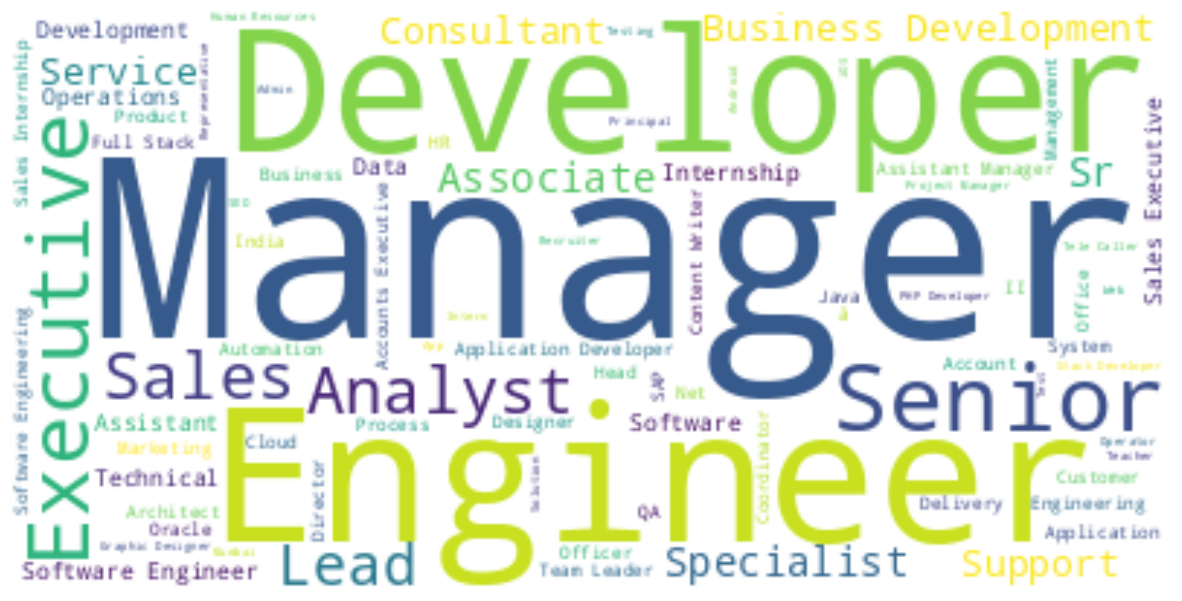

In [14]:
word_cloud("job_title")

## Company

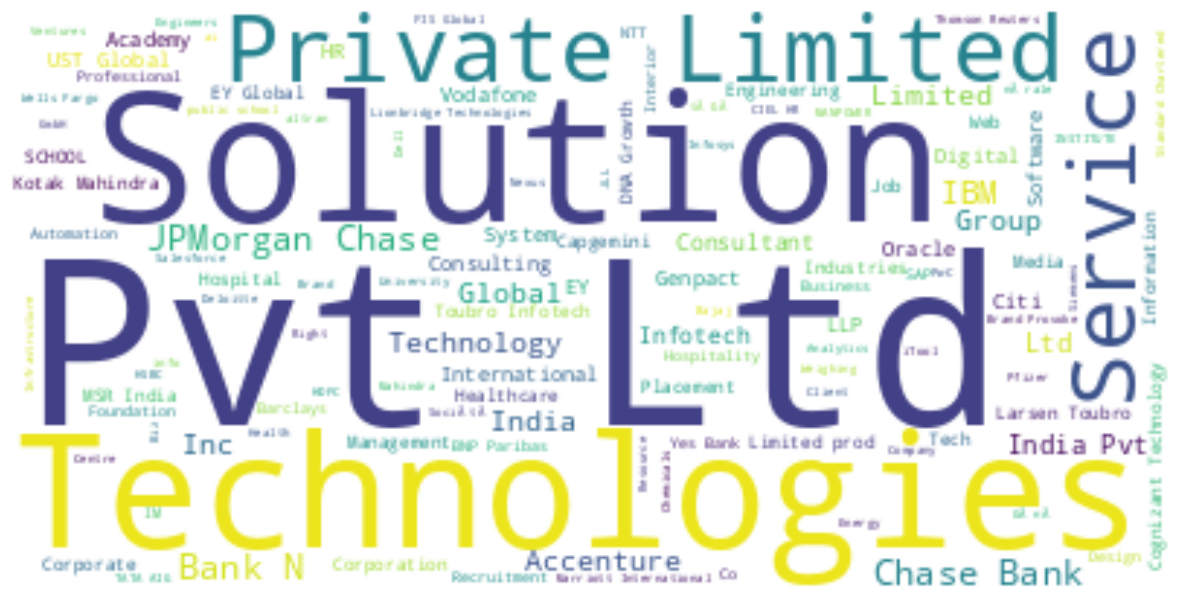

In [15]:
word_cloud("company_name")

## Company Description

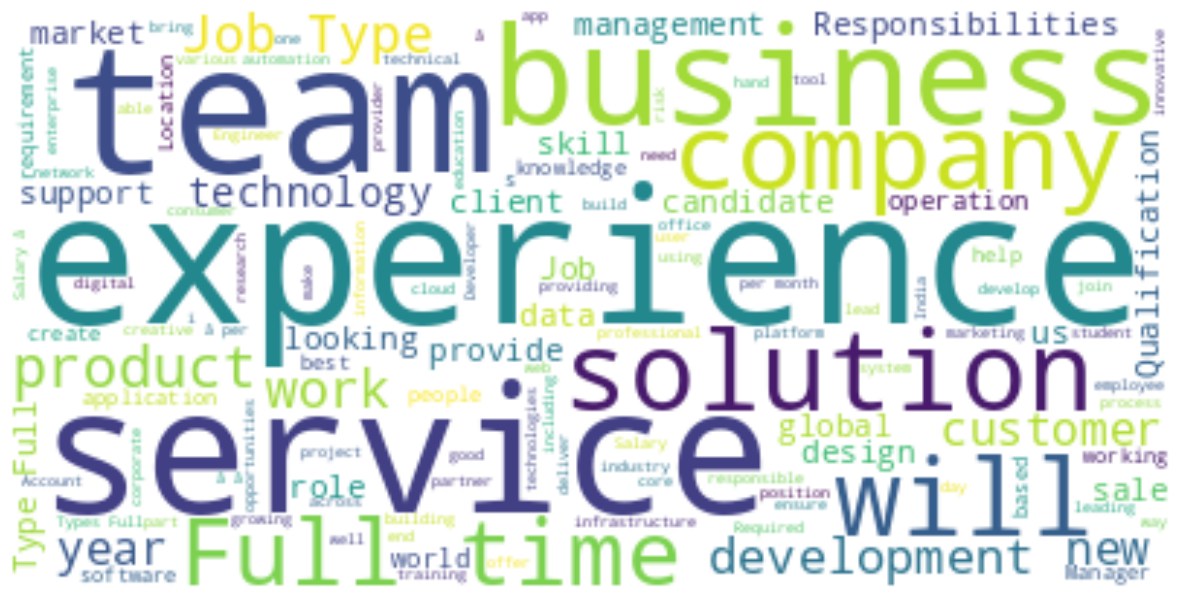

In [16]:
word_cloud("company_description")

We can infer that candidates with experience is in demand.

# Feature Extraction

In [139]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

description = job_df["job_description"].tolist()

tfidf = TfidfVectorizer(stop_words="english")
tfidf_mat = tfidf.fit_transform(description)
jd_similarity = cosine_similarity(tfidf_mat)

In [142]:
role_tfidf =TfidfVectorizer(stop_words="english") 
roles_mat = role_tfidf.fit_transform(job_df['job_title'].apply(lambda x: x.lower()).tolist())

def recommend_jobs_for_roles(role, description, k=3, j=10, m=200):
    roles_emb = role_tfidf.transform([role.lower()])
    similar_role_indices = cosine_similarity(roles_emb, roles_mat).squeeze().argsort()[-1:-(k+1):-1]

    job_vec_description_pos = jd_similarity[similar_role_indices].argsort(axis=1)[: , -1:-(j+1):-1].T.flatten()


    desc_emb = tfidf.transform([description.lower()])
    jd_sim = cosine_similarity(desc_emb, tfidf_mat[job_vec_description_pos])

    return [
        job_df.index[x]
        for x in jd_sim.squeeze().argsort()[-1:-m:-1]
    ]

In [141]:
job_df.loc[recommend_jobs_for_roles("Developer", "Professional with 5 Years of Experience in Frontend and Backend Developer" )]

[296 437  47 379 423 468 736 799 202 482 712 321 560 609 355  89 422 848
  50 848   1 303 839  50 496  47 846 961 321 171]


,job_title,company_name,company_description,job_description,job_type,category
_id,,,,,,
4db398655a6f4943b77d8e9f73752695,Talent Acquisition Partner,skilora,"TELECOMMUTE LOCATION: REMOTE, US","TELECOMMUTE LOCATION: REMOTE, US At STERIS, we...",Full-time,Facilities
8cde1f77630e10b395fccc96cc72f163,Sr HR Executive / HR Manager,Inventrax Pvt Ltd,We are a passionate group of professionals who...,Summary: We are a passionate group of professi...,Full-time,Human Resources
207ad9bd6a3c9efa6e42048397b1f3cb,Sales Executive,www.vermaindustries.net,Locations: Una Himachal Pradesh Shrinagar Utta...,Job Role: Sales Executive - Petrochemicals & B...,Full-time|Contract,Construction
48bdb1e26a592565dc377f546d85eb21,Solution Architect- Rewards,RB,None,Job Advert Want to use technology to change th...,Full-time,Management
3960736de13ec1b6eac06481e554129b,Software Development Engineer,ADCI - Karnataka,None,Programming experience with at least one moder...,Full-time,Manufacturing
6d71345a9bbb31cb4a4df47d165e8868,Manager - Program Management - DE&I,freshworks,"Headquartered in San Mateo, California, Freshw...",Freshworks makes it fast and easy for business...,Full-time,IT
8cd5967eed06fbefe33464f07fc80868,Sr Java Developer,TransUnion,What You'll Bring:,What We'll Bring: The Java Developer position ...,Full-time,Admin
0b781a19b0e6fa4f60ed0f7b33189ab9,Full Stack Developer,skilora,We are currently looking for a Full Stack Deve...,We are currently looking for a Full Stack Deve...,Full-time,Engineering
051df29e08f33c3fde80f5c2b741b244,HR Executive,Pristine Organics Pvt Ltd,1. Will be work under Pristine Organics payrol...,Job Responsibilities: 1. Will be work under Pr...,Full-time|Fresher,Fresher


In [82]:
job_df.loc["4a00e25b85e124fe1f0e920eb9feaef0"].job_description

"The Oracle Cloud Infrastructure (OCI) team can provide you the opportunity to build and operate a suite of massive scale, integrated cloud services in a broadly distributed, multi-tenant cloud environment. OCI is committed to providing the best in cloud products that meet the needs of our customers who are tackling some of the worldÃ¢â\x82¬â\x84¢s biggest challenges. We offer unique opportunities for smart, hands-on engineers with the expertise and passion to solve difficult problems in distributed highly available services and virtualized infrastructure. At every level, our engineers have a significant technical and business impact designing and building innovative new systems to power our customerÃ¢â\x82¬â\x84¢s business critical applications. OracleÃ¢â\x82¬â\x84¢s Cloud Infrastructure team is building new Infrastructure-as-a-Service technologies that operate at high scale in a broadly distributed multi-tenant cloud environment. Our customers run their businesses on our cloud, and o

In [8]:
import re

import spacy
from spacy.matcher import Matcher

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Initialize the Matcher with the shared vocabulary
matcher = Matcher(nlp.vocab)

# Define patterns to match experience-related phrases
experience_patterns = [
    # Match a number followed by "year(s)" or "yr(s)" followed by "of experience"
    [{"LIKE_NUM": True}, {"LOWER": {"in": ["years", "year", "yrs", "yr"]}}, {"LOWER": "of"}, {"LOWER": "experience"}],
    # Match a range (e.g., "4-5") followed by "years of experience"
    [{"LIKE_NUM": True}, {"TEXT": "-"}, {"LIKE_NUM": True}, {"LOWER": {"in": ["years", "yrs"]}}, {"LOWER": "of"}, {"LOWER": "experience"}],
    # Match a number followed by "year(s)" or "yr(s)" without "of experience"
    [{"LIKE_NUM": True}, {"LOWER": {"in": ["years", "year", "yrs", "yr"]}}],
]

# Add patterns to the matcher
for pattern in experience_patterns:
    matcher.add("EXPERIENCE", [pattern])


def extract_years(experience_text):
    pattern = r'(\d+)[-\s]*(\d+)?\s*(years?|yrs?)'
    match = re.search(pattern, experience_text, re.IGNORECASE)
    
    if match:
        # If it's a range (X-Y), capture both X and Y
        if match.group(2):
            return int(match.group(1)), int(match.group(2))  # Return both numbers in the range
        else:
            return int(match.group(1)), int(match.group(1))  # Return the single number twice (for consistency)
    return 0, 0



# Function to extract experience using spaCy matcher
def extract_experience(job):
    doc = nlp(job['job_description'])
    matches = matcher(doc)
    for match_id, start, end in matches:
        span = doc[start:end]
        min_yr, max_yr = extract_years(span.text)
        if min_yr > max_yr or min_yr >= 15 or max_yr >= 15 :
            continue
        return min_yr, max_yr
    return 0, 0



In [33]:
job_df[['min_exp', 'max_exp']] = job_df.apply(extract_experience, axis=1, result_type="expand")

In [34]:
job_df.head()

,job_title,company_name,company_description,job_description,job_type,category,min_exp,max_exp
_id,,,,,,,,
0b781a19b0e6fa4f60ed0f7b33189ab9,Full Stack Developer,skilora,We are currently looking for a Full Stack Deve...,We are currently looking for a Full Stack Deve...,Full-time,Engineering,5,5
4268198e459c0bef8a969e99aea58300,Windows Helpdesk Advisor,IBM,None,Introduction A Technical Support Representativ...,Full-time,Computer,2,2
921b95a255ce7c1a1088302e6309c38b,CB-WLS- Credit Support Specialist Iv- Operatio...,"JPMorgan Chase Bank, N.A.",None,Job responsibilities: Review Loan documents an...,Full-time,Healthcare,4,4
baa53877ee4fc92450b8aec70d9d3d93,Sales Executive-South Delhi,Rama Panels Pvt Ltd,Developing new Dealers & Sub dealers,"Managing existing, Dealers & Sub dealers Devel...",Full-time|Fresher,Part time,1,1
eae66e921044d585c28d340bc227fc98,Senior Software Engineer,Larsen & Toubro Infotech Limited,None,"""Manual Tester Job Description Skills and Qual...",Full-time,IT,5,5
